<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/main/notebooks/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Implementation Remote Sensing

## Import necessary packages

In [60]:
!pip install rasterio
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
# import standard python libraries
import os
import datetime as time
from datetime import datetime
import numpy as np
import pickle as pkl
import glob
from pathlib import Path
from math import floor
import random

# import data reader, logging and transforms
from torchvision import transforms
import rasterio as rio
from rasterio.plot import reshape_as_image
import wandb

# import the PyTorch deep learning library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils

# import matplotlib and enabling notebook inline plotting:
import matplotlib.pyplot as plt
%matplotlib inline

Mount Google Drive Directories for data access

In [62]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# create Colab Notebooks directory
notebook_directory = Path('/content/drive/MyDrive/Projects/DeepLearning')
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

 # create data sub-directory inside the Colab Notebooks directory
data_directory = Path('/content/drive/MyDrive/Projects/DeepLearning/data')
if not os.path.exists(data_directory): os.makedirs(data_directory)

 # create models sub-directory inside the Colab Notebooks directory
models_directory = Path('/content/drive/MyDrive/Projects/DeepLearning/models')
if not os.path.exists(models_directory): os.makedirs(models_directory)

## Helper Functions

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [65]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
if device == "cuda":
  torch.cuda.manual_seed(SEED)

## Data

Define the directory on your drive to reproduce results. Downloaded data from https://madm.dfki.de/files/sentinel/EuroSATallBands.zip should be within the data folder created in previous steps. 

In [66]:
eurosat_dir = data_directory.joinpath("ds/images/remote_sensing/otherDatasets/sentinel_2/tif")
samples = glob.glob(os.path.join(eurosat_dir, "*", "*.tif"))
len(samples)

27000

In [67]:
classes = {
    0: "AnnualCrop",
    1: "Forest",
    2: "HerbaceousVegetation",
    3: "Highway",
    4: "Industrial",
    5: "Pasture",
    6: "PermanentCrop",
    7: "Residential",
    8: "River",
    9: "SeaLake"
}

In [68]:
class_to_idx = {value:key for key,value in classes.items()}

In [69]:
print(class_to_idx)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


Create a user-defined data loader for the EuroSAT data to adjust specifically for a GAN model. This process includes transformations if wanted. 

In [70]:
def get_training_and_testing_sets(file_list):
    split = 0.8
    random.Random(SEED).shuffle(file_list)
    split_index = floor(len(file_list) * split)
    training = file_list[:split_index]
    testing = file_list[split_index:]
    return training, testing

In [71]:
train_df, test_df = get_training_and_testing_sets(samples)

In [73]:
IMAGE_SIZE = 64
transformer_train = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.Normalize([87.81586935763889, 96.97416420717593, 103.98142336697049], [51.67849701591506, 34.908630837585186, 29.465280593587384]),
                           ])

transformer_test = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.Normalize([87.81586935763889, 96.97416420717593, 103.98142336697049], [51.67849701591506, 34.908630837585186, 29.465280593587384]),
                           ])

In [74]:
class TrainData(Dataset):

    def __init__(self, directories, transform=None):
        self.directories = directories
        self.transform = transform

    def __len__(self):
      return len(self.directories)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input = self.directories[idx]
        label = input.split('/')[-1].split('_')[0]
        label = class_to_idx[label]
        with rio.open(input, "r") as d:
          image = d.read([4,3,2]).astype(int)
          image = reshape_as_image(image)

        if self.transform:
            image = self.transform(image.astype(float))
            image = image.type(torch.FloatTensor)

        return image, label

In [75]:
trainData = TrainData(directories = train_df, transform = transformer_train)

In [78]:
trainData[0][0].shape

torch.Size([3, 64, 64])

In [79]:
class TestData(Dataset):
    def __init__(self, directories, transform=None):
        self.directories = directories
        self.transform = transform

    def __len__(self):
      return len(self.directories)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input = self.directories[idx]
        label = input.split('/')[-1].split('_')[0]
        label = class_to_idx[label]
        with rio.open(input, "r") as d:
          image = d.read([4,3,2]).astype(int)
          image = reshape_as_image(image)

        if self.transform:
            image = self.transform(image.astype(float))
            image = image.type(torch.FloatTensor)

        return image, label

In [80]:
testData = TestData(directories = test_df, transform = transformer_test)

In [81]:
testData[0][0].shape

torch.Size([3, 64, 64])

## Setup GAN 
The GAN architecture is composed of the generative model $G$ and the discriminative model $D$.

The discriminator $D$ is a binary classifier trying to determine whether the input sample $X$ is real or fake. Real pictures come from the EuroSAT dataset whereas fake inputs are generated by generator $G$. Thus, $D$ outputs a scalar which is then transformed to a probability measure using the sigmoid function. 

- 1 - Sample is part of the real dataset
- 0 - Sample is a fake generated by $G$

In a first case we try to implement the DC-GAN as in ([PyTorch DC-GAN](https://https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html))

In [82]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [83]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Discriminator
Due to the binary classification case of the discriminator we will use the BCE with logits loss because cross entropy not only punishes incorrect but confident predictions but also correct but less confident predictions. Including the logits there is no need to apply the sigmoid activation function in the network. 

In [84]:
# implement the Discriminator network architecture
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

### Generator
As the generator is not a discriminative model its aim is to generate data. 
Thus, we draw the latent variable $z \in \mathbb{R}^d$ from a random distribution such as a Gaussian or a uniform distribution. 
Accordingly, $G$ produces the following output: $X' = G(z)$. 
As we want to fool $D$ to fail in distinguishing fake and real remote sensing data we aspire $D(G(z)) ≈ 1$. Hence, the goal is to maximize cross-entropy loss in case $y=0$ (fake data). 

In [85]:
# implement the Generator network architecture

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

### MinMax-Game
We thus define the following value function $V$ by combining both the targets of $G$ and $D$:

$$min_{G}max_{D} V(D, G) = \mathbb{E}_{x∼Data} [logD(x)] + \mathbb{E}_{z∼Noise} [log(1-D(G(z)))]$$


In [86]:
# instantiate both D and G
D = Discriminator(ngpu).to(device)
G = Generator(ngpu).to(device)

In [87]:
# initialize the weights
D.apply(weights_init)
G.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [88]:
# check whether model is loaded to GPU
!nvidia-smi

Thu Oct 13 09:41:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |   1278MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [89]:
print('[LOG] Discriminator architecture:\n\n{}\n'.format(D))

[LOG] Discriminator architecture:

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
 

In [90]:
print('[LOG] Generator architecture:\n\n{}\n'.format(G))

[LOG] Generator architecture:

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [91]:
# define the loss for the discriminator and push to device
criterion = nn.BCELoss()
criterion = criterion.to(device)

For further training tips of GANs look at: [GAN hacks](https://https://github.com/soumith/ganhacks)

In [92]:
# set learning rate
lr = 0.002

# create optimizers for the discriminator and generator
d_optimizer = optim.SGD(D.parameters(), 0.02) 
g_optimizer = optim.Adam(G.parameters(), 0.002) 

## Training

In [93]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size=64 # size of the mini-batches

In [94]:
train_loader = torch.utils.data.DataLoader(trainData, 
                                           batch_size=mini_batch_size,
                                           shuffle=True
                                           )

In [95]:
len(train_loader)

338

In [96]:
# establish convention for real and fake labels during training
real_label = 1
fake_label = 0

In [97]:
# define size of latent vector
z_size = 100

# define sample size
sample_size = 4

# uniformly distribute data of size z_size over an interval of -1; 1
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [59]:
# initialize list of the generated (fake) images
fake_images = []

# initialize collection of batch losses
D_batch_losses = []
G_batch_losses = []

# initialize collection of epoch losses
D_epoch_losses = []
G_epoch_losses = []

# set networks to training mode
D.train()
G.train()

# define time right before training
start = time.datetime.now()

# train the GANs
for epoch in range(num_epochs):

    # iterate over mini batches
    for i, data in enumerate(train_loader, 0):

        # define real images and push to computation device
        real_images = data[0].to(device)

        # define batch size as size of the images to make sure the loader is emptied completely
        batch_size = real_images.size(0)

        # --------------------------------------------------------------------------
        # (1) Update Discriminator network

        #### train with real images

        # create tensor of same size as mini-batch and filled with 1's (real_label)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        # rescaling input images from [0,1) to [-1, 1), which is needed for network
        real_images = real_images*2 - 1

        # run forward pass through Discriminator
        output = D(real_images).view(-1)

        # reset graph gradients
        D.zero_grad()

        # determine loss on Discriminator
        errD_real = criterion(output, label)

        # run backward pass
        errD_real.backward()
    
        #### train with fake images

        # generate batch of latent vectors
        z = torch.randn(64, nz, 1, 1, device=device)

        # generate fake image batch with Generator
        fake = G(z)

        # fills label tensor with 0's (fake_label)
        label.fill_(fake_label)

        # classify all fake batch with Discriminator
        output = D(fake.detach()).view(-1)

        # get discriminator loss on the fake batch
        errD_fake = criterion(output, label)

        # run backward pass
        errD_fake.backward()

        # compute error of Discriminator as sum of loss over the fake and the real batches
        errD = errD_fake + errD_real

        # update Discriminator parameters
        d_optimizer.step()


        # --------------------------------------------------------------------------
        # (2) Update Generator network

        # reset graph gradients
        G.zero_grad()

        # fake labels are real for generator
        label.fill_(real_label)

        # since we just updated D, perform another forward pass of fake batch through the Discriminator
        output = D(fake).view(-1)

        # get Generator loss based on this output
        errG = criterion(output, label)

        # run backward pass
        errG.backward()

        # update Generator paramaters
        g_optimizer.step()

        # --------------------------------------------------------------------------

        # each 250 iterations (4x per epoch), print losses
        if i % 100 == 0:
          now = datetime.utcnow().strftime("%H:%M:%S")
          print('[LOG {}] Epoch [{}/{}] \t[{}/{}] \t d_loss: {} \t g_loss: {}'.format(
              now, epoch+1, num_epochs,i, len(train_loader), errD.item(), errG.item()))
          
        # save losses for plotting later
        D_batch_losses.append(errD.item())
        G_batch_losses.append(errG.item())

        # set Generator to eval mode for generating samples (equivalent to 'testing' the model)
        G.eval() 

        # make Generator generate samples from the fixed noise ditribution
        samples = G(fixed_noise.float())

        # if you are using a GPU, copy tensor to host memory (cpu) - needed for later operations
        if device == 'cuda':
          samples = samples.cpu()

        # append generated fixed samples to the fake_images list
        fake_images.append(samples)

        # set Generator back to train mode
        G.train()

    # determine mean min-batch loss of epoch
    D_epoch_loss = np.mean(D_batch_losses)

    D_epoch_losses.append(D_epoch_loss)

    # determine mean min-batch loss of epoch
    G_epoch_loss = np.mean(G_batch_losses)

    G_epoch_losses.append(G_epoch_loss)

    # set filename of actual model
    d_model_name = 'gan_d_model_epoch_{}.pth'.format(str(epoch+1))

    # set filename of actual model
    g_model_name = 'gan_g_model_epoch_{}.pth'.format(str(epoch+1))

    # save current model to GDrive models directory
    torch.save(D.state_dict(), os.path.join(models_directory, d_model_name))

    # save current model to GDrive models directory
    torch.save(G.state_dict(), os.path.join(models_directory, g_model_name))

# save generated samples with pickle
with open('fake_images.pkl', 'wb') as f:
  pkl.dump(fake_images, f)

# print total training time
print('\nTotal training time:', time.datetime.now() - start)

[LOG 14:58:48] Epoch [1/20] 	[0/338] 	 d_loss: 12.75304126739502 	 g_loss: 46.377685546875


RuntimeError: ignored

In [98]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        d_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        g_optimizer.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainData),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainData)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/20][0/21600]	Loss_D: 1.7085	Loss_G: 12.1167	D(x): 0.4110	D(G(z)): 0.4505 / 0.0000
[0/20][50/21600]	Loss_D: 0.0195	Loss_G: 10.4809	D(x): 1.0000	D(G(z)): 0.0188 / 0.0089
[0/20][100/21600]	Loss_D: 1.0296	Loss_G: 20.4883	D(x): 0.9998	D(G(z)): 0.1664 / 0.0033
[0/20][150/21600]	Loss_D: 14.8644	Loss_G: 11.6806	D(x): 0.0747	D(G(z)): 0.0001 / 0.4293
[0/20][200/21600]	Loss_D: 11.6811	Loss_G: 17.1191	D(x): 0.9885	D(G(z)): 0.7894 / 0.0000
[0/20][250/21600]	Loss_D: 2.3720	Loss_G: 11.5720	D(x): 0.9842	D(G(z)): 0.5014 / 0.0006
[0/20][300/21600]	Loss_D: 1.7477	Loss_G: 5.5720	D(x): 0.4501	D(G(z)): 0.0358 / 0.1233
[1/20][0/21600]	Loss_D: 0.5166	Loss_G: 6.8660	D(x): 0.8612	D(G(z)): 0.0413 / 0.0630
[1/20][50/21600]	Loss_D: 11.7442	Loss_G: 4.8202	D(x): 0.9663	D(G(z)): 0.2371 / 0.1401
[1/20][100/21600]	Loss_D: 7.8749	Loss_G: 11.8445	D(x): 0.9999	D(G(z)): 0.8119 / 0.0011
[1/20][150/21600]	Loss_D: 2.6014	Loss_G: 5.2261	D(x): 0.8743	D(G(z)): 0.7266 / 0.1740
[1/20][200/21600]	Loss_D

KeyboardInterrupt: ignored

In [99]:
# save current model to GDrive models directory
torch.save(D.state_dict(), os.path.join(models_directory, "D_epoch_20"))

# save current model to GDrive models directory
torch.save(G.state_dict(), os.path.join(models_directory, "G_epoch_20"))

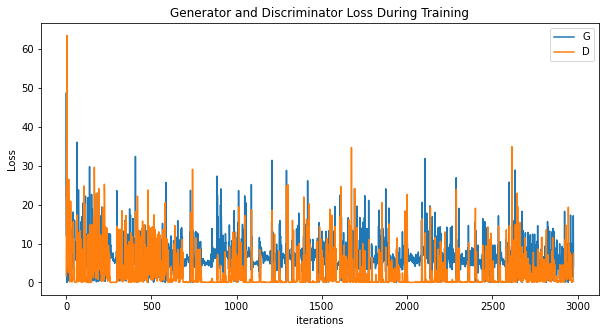

In [100]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

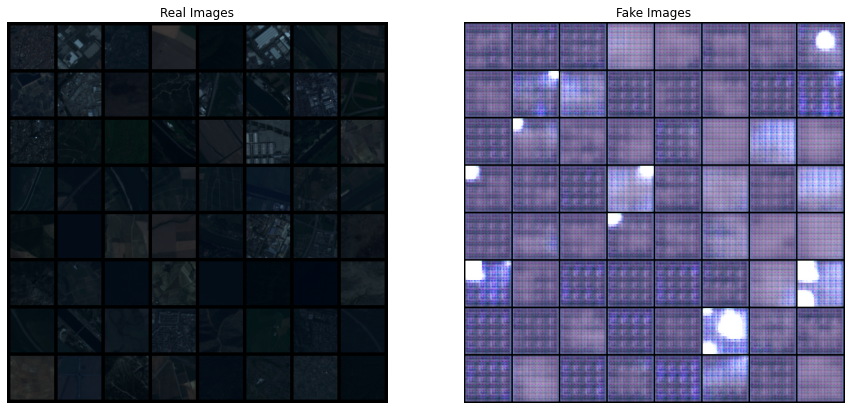

In [105]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()